# MNIST CNN VAE
This notebook demonstrates the encoding of MNIST written numeral data using a simple convolution neural network (CNN) variational autoencoder (VAE) with much code borrowed from [Keras Examples Variational Autoencoder Deconvolution](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py) which in turn is based on ["Auto-encoding variational bayes."](https://arxiv.org/abs/1312.6114).

This notebook specifically uses the Keras API for Tensorflow so as to help understand how models are built using Keras.

This notebook is being used to:
1. Understand the Keras API
2. Understand VAE
3. Understand deep learning in general

For this reason if there is something incorrect or you think could be done better please let me know. I make no claim that everything in her is correct, but I do try my best.

# Import modules and important packages

In [1]:
import tensorflow as tf
print(tf.__version__)
tf.reset_default_graph()

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1.12.0


# Import Data
Here we import the data using the Keras provided MNIST dataset.
We then select a random image in the training dataset to demonstrate the need for normalizing the data between 0 and 1 rather than 0 and 255.

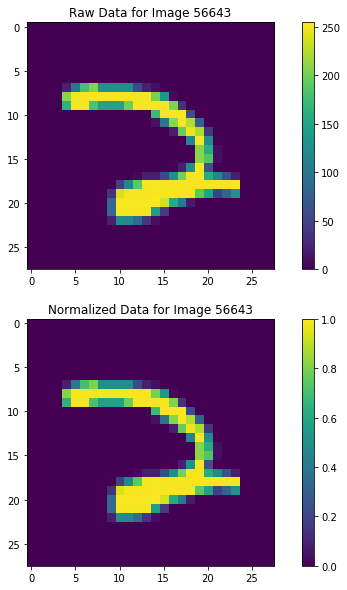

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
img_index = np.random.randint(0,X_train.shape[0]-1)

# Raw data
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(X_train[img_index])
plt.title('Raw Data for Image ' + str(img_index))
plt.colorbar()

# Processed data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
plt.subplot(212)
plt.title('Normalized Data for Image ' + str(img_index))
plt.imshow(X_train[img_index])
plt.colorbar()

# Reshaping data
image_size = X_train.shape[1]
X_train = np.reshape(X_train, [-1, image_size, image_size, 1])
X_test  = np.reshape(X_test,  [-1, image_size, image_size, 1])

# Control variables


In [3]:
# n_latent: The number of latent variables to map to in the encoder network. 
# original_dim: Length of vector for image data
# intermediate_dim: Length of hidden layer
n_latent = 2
input_shape = (image_size, image_size, 1)
epochs = 10
batch = 128
filters = 16
kernel_size = 3

# Encoder
Here we begin the code for the encoder network. We start by definind a function _sampling_ that will take in the latent space tensors and generate a new tensor that is a sampling on the normal distribution N(0,1). We do this by applying a *Labmda* layer, which is a wrapping of a function on the inputs of the function. This is required because the tensorflow background requires the data to flow as a tensor the whole way through. If we were to just apply this function directly to the tensor outside a layer an error would be thrown.

This encoder starts with an input layer (required for this kind of instantiation). It then applies 2 Conv2D layers with 32 and then 64 layers respectively. After that the data is Flattened to feed it into a fully-connected layers of 16 nodes, which then feeds 2 separate fully connected nodes for the mean and stddev of the image.

In [4]:
def sampling(args):
    mn, sd = args
    batch = tf.shape(mn)[0]
    dim = tf.shape(mn)[1]
    eps = tf.random_normal(shape=(batch,dim))
    return mn + tf.exp(0.5 * sd) * eps


inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              activation='relu',
              strides=2,
              padding='same')(x)
    
shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(n_latent, name='z_mean')(x)
z_log_var = Dense(n_latent, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(n_latent,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense (Den

# Decoder
Here we begin the code for the decoder network. It is a very simply MLP that takes in the latent space, passes it through a single dense layer and outputs a 784 length vector using a sigmoid activation function.

In [5]:
latent_inputs = Input(shape=(n_latent,),name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_________________________________________________________________


# Full Model

Here we generate the full model by running the encoder model with _inputs_ and then feeding the sampled _z_ variable to the decoder.

We then define the loss function as a combination of either MSE OR Binary Crossentropy loss _plus_ KL Divergence Loss and manually set the loss fuction for _vae_.

Interestingly, the BCE reconstruction loss gives a better distribution in a N=2 latent space. With MSE loss it was only the primary latent variable that really had an effect on the output.



In [6]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs,outputs, name='vae_cnn')
vae.summary()

# reconstruction_loss = tf.keras.losses.mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
deco

# Training

In [7]:
vae.fit(X_train,
        epochs=epochs,
        batch_size=batch,
        validation_data=(X_test, None))

vae.save_weights('vae_cnn_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 20s 336us/step - loss: 215.8008 - val_loss: 179.3660
Epoch 2/10
60000/60000 [==============================] - 16s 266us/step - loss: 172.2034 - val_loss: 167.8620
Epoch 3/10
60000/60000 [==============================] - 16s 263us/step - loss: 164.9918 - val_loss: 163.6849
Epoch 4/10
60000/60000 [==============================] - 16s 260us/step - loss: 161.4164 - val_loss: 159.9627
Epoch 5/10
60000/60000 [==============================] - 16s 261us/step - loss: 159.4208 - val_loss: 159.0689
Epoch 6/10
60000/60000 [==============================] - 16s 260us/step - loss: 158.1081 - val_loss: 157.1835
Epoch 7/10
60000/60000 [==============================] - 16s 264us/step - loss: 157.0438 - val_loss: 156.3028
Epoch 8/10
60000/60000 [==============================] - 16s 267us/step - loss: 156.1975 - val_loss: 156.2966
Epoch 9/10
60000/60000 [==============================] - 16s 

# Generate a new image

Here we are sampling a random normal distribution via the variable _sample_ and then feeding that into the _decoder_ network. This then generates a novel image based on the latent space sampling of mean and stddev. Running the cell muliple times will generate new novel images for each sampling.

It is worth noting that the network does not know what it is generating and cannot be controlled directly at this point. Only by understanding the latent space (or developing hooks into the latent space) can we deterministically generate a given numeral.

Sampled Point: [[-0.91510186 -1.2518501 ]]


Text(0.5, 1.0, 'Generated Image')

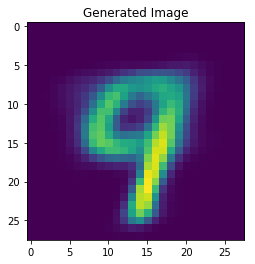

In [38]:
sample = np.random.normal(size=(1,n_latent))
print('Sampled Point: '+ str(sample))
sample_image = decoder.predict(sample)
sample_image = sample_image.reshape(28,28)
plt.imshow(sample_image)
plt.title('Generated Image')

# Show latent space

Here we run the encoder model to generate the latent space vectors of the images. The latent space vectors (mean & stddev) are then plotted by color to show the general domains they occupy in the latent space.

By visualizing the data in this way we can see how the data overlap by different numerals and which numerals intuitively have characteristics in common. For example, the numeral "0" (dark purple) is on the far left of z_mean[0] while the numeral "1" (deep blue) is on the far right of z_mean[0]. This indicates there is significant distance in the latent space between the two numerals.

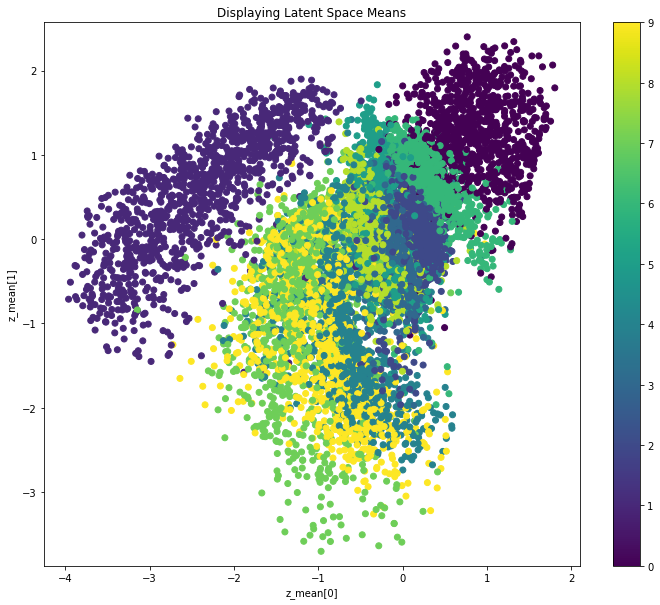

In [29]:
z_mean, z_std, z= encoder.predict(X_test)
plt.figure(figsize=(12,10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=Y_test)
plt.axis('equal')
plt.colorbar()
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
# plt.savefig('latent_space_001.png')
plt.title('Displaying Latent Space Means')
plt.show()

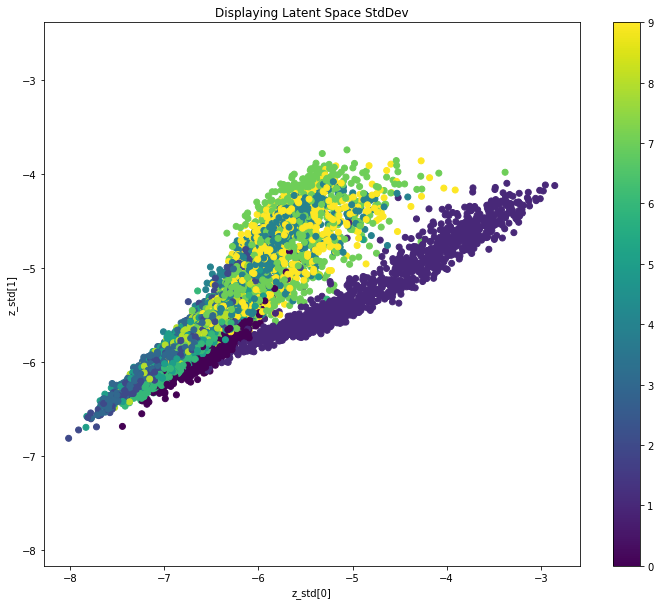

In [10]:
plt.figure(figsize=(12,10))
plt.scatter(z_std[:, 0], z_std[:, 1], c=Y_test)
plt.axis('equal')
plt.colorbar()
plt.xlabel("z_std[0]")
plt.ylabel("z_std[1]")
# plt.savefig('latent_space_002.png')
plt.title('Displaying Latent Space StdDev')
plt.show()

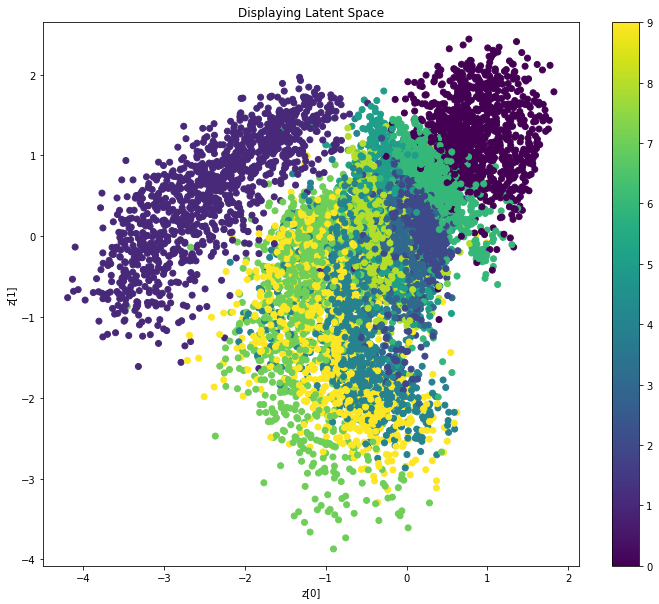

In [28]:
plt.figure(figsize=(12,10))
plt.scatter(z[:, 0], z[:, 1], c=Y_test)
plt.axis('equal')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
# plt.savefig('latent_space_002.png')
plt.title('Displaying Latent Space')
plt.show()